Run on NERSC

In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from matplotlib.colors import LogNorm

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
fn = '/global/u1/d/dstn/legacypipe/py/halo-535126-S14.fits'

tt = Table.read(fn, hdu=1)
index = np.argmin(tt['phot_g_mean_mag'])
print(index)
# tt[[index]]
tt[['ra', 'dec', 'phot_g_mean_mag', 'decam_mag_r', 'phot_rp_mean_mag', 'phot_bp_mean_mag', 'decam_mag_z', 'decam_mag_g', 'radius_pix', 'halo_radius_pix', 'outer_moffat_a', 'outer_moffat_b', 'outer_moffat_w', 'outer_powerlaw_w', 'inner_moffat_a', 'inner_moffat_b', 'x_in_sub_ccd', 'y_in_sub_ccd']][index]

14


<Row index=14>
      ra          dec     phot_g_mean_mag decam_mag_r phot_rp_mean_mag phot_bp_mean_mag decam_mag_z decam_mag_g radius_pix halo_radius_pix outer_moffat_a outer_moffat_b outer_moffat_w outer_powerlaw_w inner_moffat_a inner_moffat_b x_in_sub_ccd y_in_sub_ccd
   float64      float64       float32       float32       float32          float32        float32     float32     int64        float32        float32        float32        float32         float32         float32        float32        int16        int16    
------------- ----------- --------------- ----------- ---------------- ---------------- ----------- ----------- ---------- --------------- -------------- -------------- -------------- ---------------- -------------- -------------- ------------ ------------
148.121840296 31.54267097         7.45631     7.31362          6.84167          7.96333     7.00524     8.03766        443           763.0            0.0            0.0            0.0          0.00045        1.75678        3.87452         1211          372

In [5]:
tt[['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'decam_mag_g', 'decam_mag_r', 'decam_mag_z']][[index]]

<Table length=1>
      ra          dec     phot_g_mean_mag ... decam_mag_r decam_mag_z
   float64      float64       float32     ...   float32     float32  
------------- ----------- --------------- ... ----------- -----------
148.121840296 31.54267097         7.45631 ...     7.31362     7.00524

In [6]:
model = fitsio.read(fn, ext=2)
print(model.shape)

img = fitsio.read(fn, ext=3)
print(img.shape)

(1875, 1489)
(1875, 1489)


In [7]:
xpixcenter, ypixcenter = tt['x_in_sub_ccd'][index], tt['y_in_sub_ccd'][index]
print(xpixcenter, ypixcenter)
print(img.shape[1]-xpixcenter, img.shape[0]-ypixcenter)

1211 372
278 1503


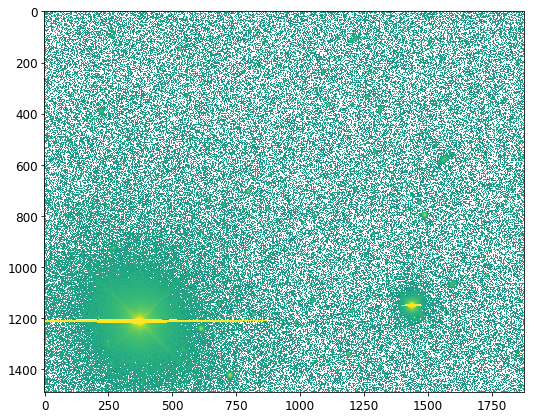

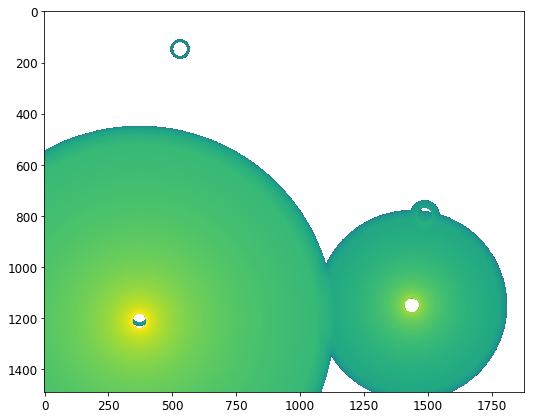

In [8]:
plt.figure(figsize=(15, 7))
plt.imshow(img.T, norm=LogNorm())
plt.show()

plt.figure(figsize=(15, 7))
plt.imshow(model.T, norm=LogNorm())
plt.show()

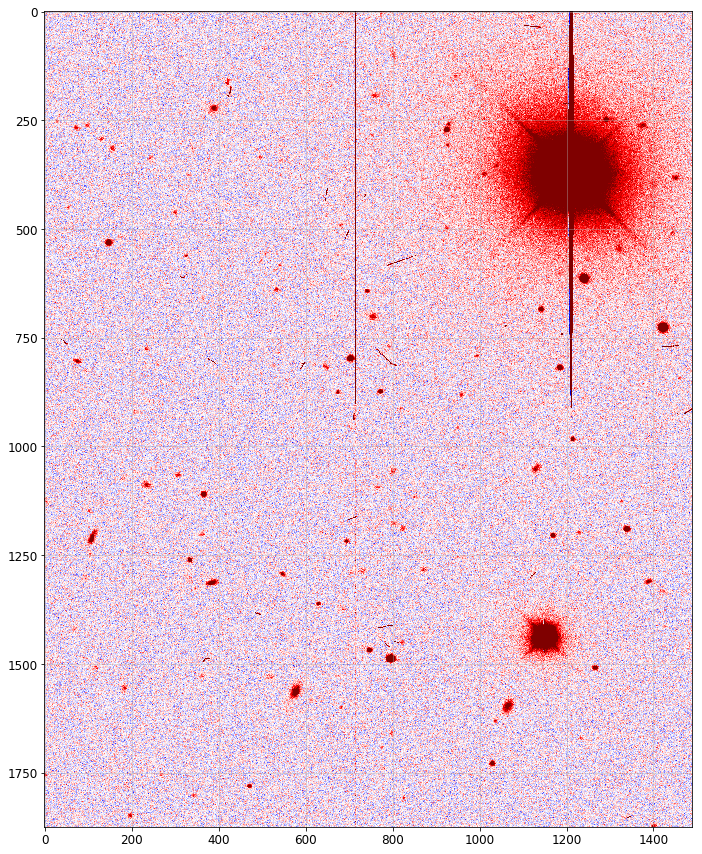

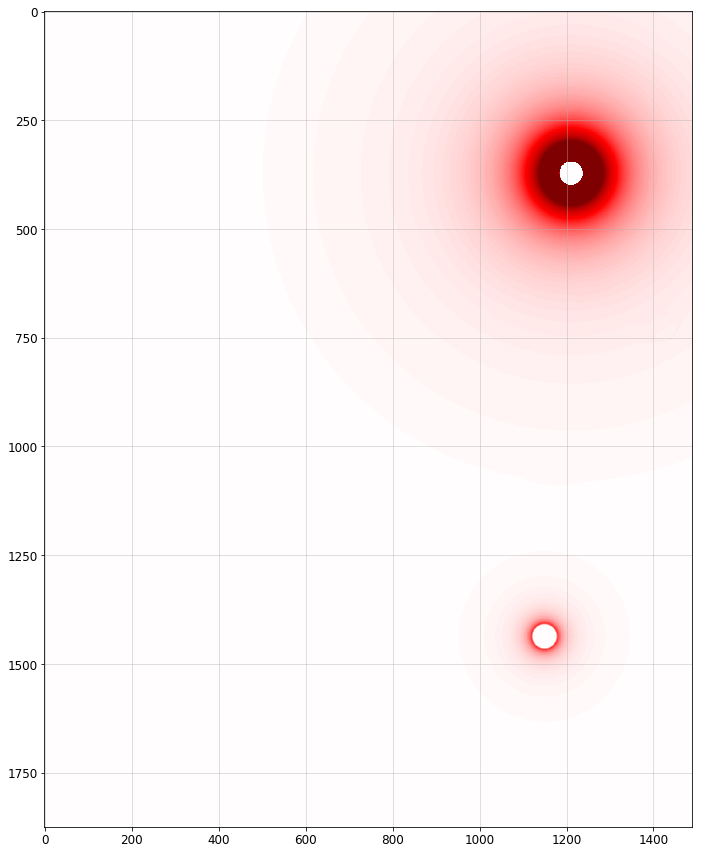

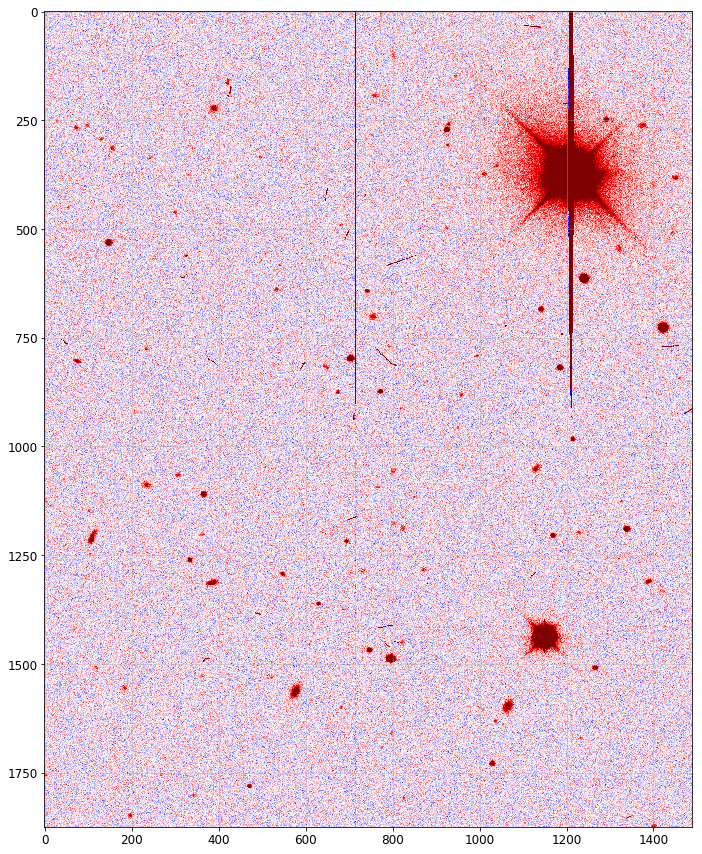

In [9]:
vrange = 0.5e-1

plt.figure(figsize=(15, 15))
plt.imshow(img, vmin=-vrange, vmax=vrange, cmap='seismic')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(model, vmin=-vrange, vmax=vrange, cmap='seismic')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(img-model, vmin=-vrange, vmax=vrange, cmap='seismic')
plt.grid(alpha=0.5)
plt.show()

In [10]:
pixscale = 0.262

xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
xx, yy = np.meshgrid(xgrid, ygrid)

ccddecoff = pixscale*(xpixcenter-(img.shape[1]/2+0.5))
ccdraoff = pixscale*(ypixcenter-(img.shape[0]/2+0.5))
xx, yy = xx - ccddecoff, yy - ccdraoff

radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

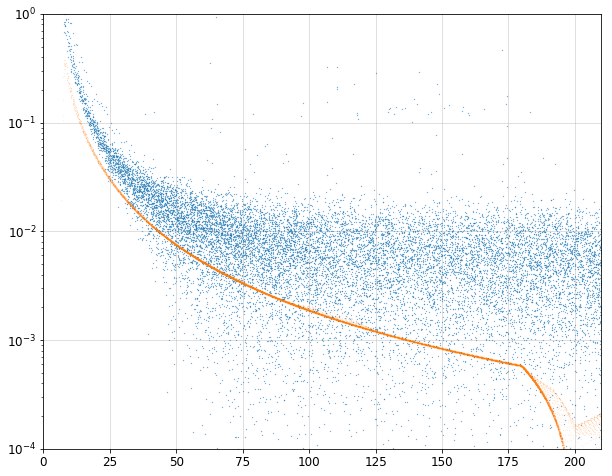

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.5)
plt.plot(radius[::50], model.flatten()[::50], '.', ms=0.1)
plt.yscale('log')
plt.xlim(0, 210)
plt.ylim(1e-4, 1e0)
plt.grid(alpha=0.5)
plt.show()

In [14]:
6e-4/(0.262**2)

0.008740749373579626

In [16]:
22.5-2.5*np.log10(6e-4/(0.262**2))

27.64612833063962

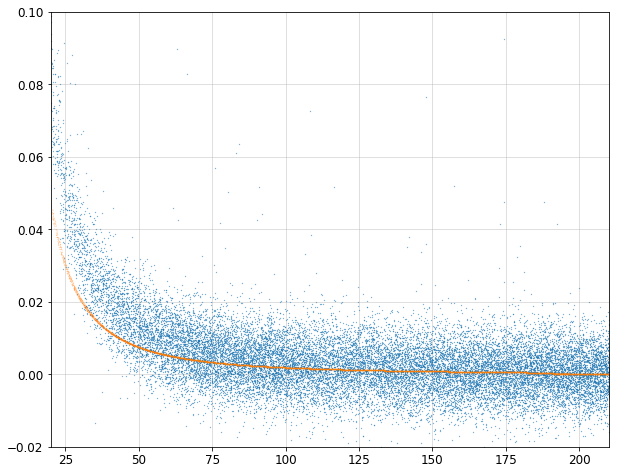

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.5)
plt.plot(radius[::50], model.flatten()[::50], '.', ms=0.1)
# plt.yscale('log')
plt.xlim(20, 210)
plt.ylim(-2e-2, 1e-1)
plt.grid(alpha=0.5)
plt.show()

In [20]:
def binned_median(x, y, bins):
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median = np.zeros((2, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
        else:
            bin_median[index] = np.nan
    return bin_center, bin_median

In [21]:
def binned_mean(x, y, bins):
    nmad = lambda x: 1.4826*np.mean(np.abs(x-np.mean(x)))
    bin_center, bin_mean = np.zeros((2, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.mean(x[mask])
        if np.sum(mask)>0:
            bin_mean[index] = np.mean(y[mask])
        else:
            bin_mean[index] = np.nan
    return bin_center, bin_mean

In [22]:
radius_bin, img_bin = binned_median(radius, img.flatten(), bins=np.arange(0, 300, 2))
# radius_bin, img_bin = binned_mean(radius, img.flatten(), bins=np.arange(0, 300, 2))

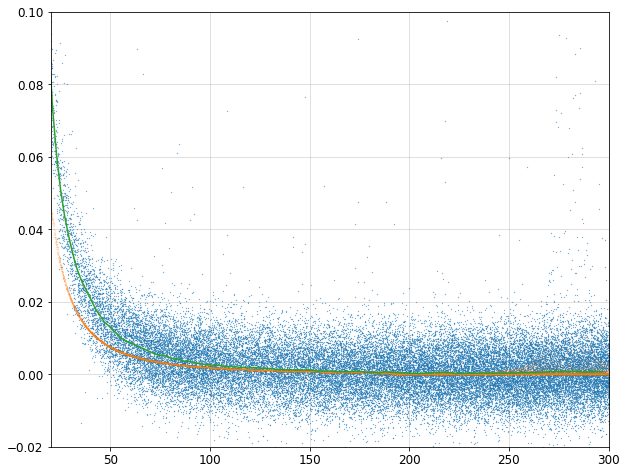

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.5)
plt.plot(radius[::50], model.flatten()[::50], '.', ms=0.1)
plt.plot(radius_bin, img_bin)
# plt.yscale('log')
plt.xlim(20, 300)
plt.ylim(-2e-2, 1e-1)
plt.grid(alpha=0.5)
plt.show()

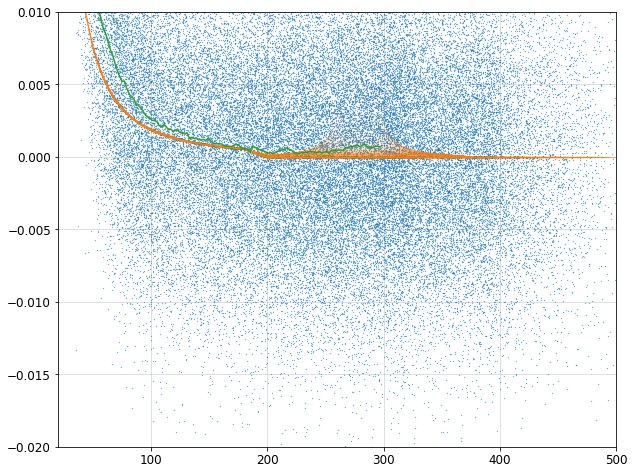

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.5)
plt.plot(radius[::50], model.flatten()[::50], '.', ms=0.1)
plt.plot(radius_bin, img_bin)
# plt.yscale('log')
plt.xlim(20, 500)
plt.ylim(-2e-2, 1e-2)
plt.grid(alpha=0.5)
plt.show()

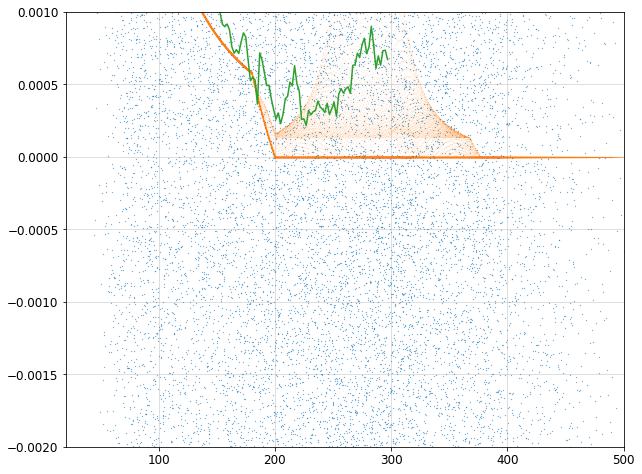

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.5)
plt.plot(radius[::50], model.flatten()[::50], '.', ms=0.1)
plt.plot(radius_bin, img_bin)
# plt.yscale('log')
plt.xlim(20, 500)
plt.ylim(-2e-3, 1e-3)
plt.grid(alpha=0.5)
plt.show()